In [11]:
import pandas as pd # type: ignore
import json
import re
import numpy as np
import warnings
from datetime import datetime
import matplotlib.pyplot as plt

### Import the data and make it workable

In [12]:
# append_paths = [f'../data/raw/by_pages/page_{page_num}_apps.json' for page_num in range(0,3000)]
# apps = []
# for page_path in append_paths:
#     page = json.loads(open(page_path, 'r').read())
#     apps.extend(page)
# with open('workable_apps.json','w')as f:
#     json.dump(apps, f, indent=4)

In [13]:
with open('workable_apps.json','r')as f:
    apps = json.loads(f.read())


In [14]:
df = pd.DataFrame([app for app in apps if app])
df.shape

(17583, 33)

In [15]:
n_na = df.isna().sum(axis=0)
n_na.round(2)  # Percentage of missing values
df.shape

(17583, 33)

In [16]:
df.head(5)

,name,category,developer,release,setup_size,setup_type,compatibility,operating_system,ram_required,hdd_space,...,extra_10,extra_11,extra_12,extra_13,extra_14,extra_15,extra_16,extra_17,extra_18,extra_19
0,Valentina Studio Pro 2024,"Database, Development",Valentina Studio Pro,10th July 2024,118 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,1 GB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Paragon APFS for Windows 2024,Softwares,Paragon APFS for Windows,10th July 2024,36 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,100 MB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Master Packager Pro 2024,Installer Creation,Master Packager Pro,10th July 2024,66 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,500 MB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Topaz Gigapixel AI 2024,"Photo Editing, Photo Retouching",Topaz Gigapixel,10th July 2024,286 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,200 MB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Navicat Premium 2024,3D Designing,Navicat,10th July 2024,184 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/10,1 GB,100 MB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df['category'].str.find(',')

0         8
1        -1
2        -1
3        13
4        -1
         ..
17578    -1
17579    -1
17580    -1
17581    -1
17582    -1
Name: category, Length: 17583, dtype: int64

In [18]:
df.query("developer == 'Paragon'")

,name,category,developer,release,setup_size,setup_type,compatibility,operating_system,ram_required,hdd_space,...,extra_10,extra_11,extra_12,extra_13,extra_14,extra_15,extra_16,extra_17,extra_18,extra_19
8816,Paragon ReFS for Windows,Utilities,Paragon,07th Aug 2020,30 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/8.1/10.,512 MB of RAM required.,40 MB of free space required.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14047,Paragon Hard Disk Manager Advanced 2019,Utilities,Paragon,10th Jan 2019,"138 MB, 155 MB",Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows XP/Vista/7/8/8.1/10,512 MB of RAM required.,400 MB of free space required.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15528,Paragon Hard Disk Manager 15 Premium,Utilities,Paragon,19th Feb 2018,"470 MB, 737 MB",Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/8.1/10,256 MB of RAM required.,900 MB of free space required.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We can clean the columns with units example: hdd_space, ram, setup size, and also cpu

#### These are some cleaning functions

In [19]:
import datetime as dt

def parse_memory(x: str):
   try:
      # Extract the number part from the string
      number = re.search(r'\d+(\.\d+)?', x).group()
      number = float(number)  # Convert the extracted number to a float
   except (AttributeError, ValueError, TypeError):
      return np.nan  # Return NaN if no valid number is found

   # Determine the unit and convert accordingly
   if re.search(r'(MB|mb)', x):
      return number
   elif re.search(r'(KB|kb)', x):
      return number / 1000
   elif re.search(r'(GB|gb)', x):
      return number * 1000
   return np.nan 

def parse_compatibility(x: str):
   try:
      matches =  re.findall(r'(32|64|86)', x)
   except TypeError:
      return np.nan
   if matches:
      if '86' in matches:
         matches.remove('86')
         matches.insert(0, '32')
      matches = list(set(matches))
      matches = [int(num) for num in matches]
      return min(matches)
   else:
      return np.nan
   
def parse_date(date_str):
   try:
      # Remove the ordinal suffix (st, nd, rd, th)
      date_str = re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_str)
      # Convert to datetime
      return pd.to_datetime(date_str, format='%d %B %Y')
   except Exception as e:
        np.nan
    
def categorize_os(value):
   try:  
      if re.search(r"7/8/8\.1/10", value):
         return "Modern Versions"
      elif re.search(r"7/8/10", value):
         return "Modern Versions"
      elif re.search(r"(2000/)?XP/Vista/7/8(/8\.1)?/10", value):
         return "All Windows versions"
      elif re.search(r"XP/Vista/7", value):
         return "Older Windows versions"
      else:
         return "Other"
   except TypeError:
      return np.nan


In [20]:
newdf = df.copy()

In [21]:
# parse_date(newdf.release[0])
newdf['release'] = newdf['release'].map(parse_date)
newdf['setup_size_MB'] = newdf['setup_size'].map(parse_memory)
newdf['hdd_space_MB'] = newdf['hdd_space'].map(parse_memory)
newdf['ram_required_MB'] = newdf['ram_required'].map(parse_memory)
newdf['minimum_os_bits']  = newdf['compatibility'].map(parse_compatibility)
newdf['os_version'] = newdf['operating_system'].map(categorize_os)
newdf = newdf.drop(['setup_size', 'setup_type','compatibility', 'operating_system', 'ram_required', 'hdd_space'], axis=1)

In [22]:
for col in list(newdf.columns):
    if col.startswith('extra'):
        newdf = newdf.drop(col, axis=1)

newdf.drop('release', axis=1, inplace=True)

In [23]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17583 entries, 0 to 17582
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             17583 non-null  object 
 1   category         17583 non-null  object 
 2   developer        16355 non-null  object 
 3   cpu              17443 non-null  object 
 4   img_link         17569 non-null  object 
 5   desc             17583 non-null  object 
 6   features         17583 non-null  object 
 7   setup_size_MB    17011 non-null  float64
 8   hdd_space_MB     16670 non-null  float64
 9   ram_required_MB  16462 non-null  float64
 10  minimum_os_bits  16954 non-null  float64
 11  os_version       17443 non-null  object 
dtypes: float64(4), object(8)
memory usage: 1.6+ MB


In [24]:
newdf['category'] = newdf['category'].astype("category")
newdf['os_version'] = newdf['os_version'].astype("category")
newdf['developer'] = newdf['developer'].astype("category")

In [25]:
newdf.dropna(inplace=True)

In [26]:
newdf = newdf.dropna().reset_index(drop=True)

In [27]:
newdf.shape

(15107, 12)

Text(0.5, 0, 'App count')

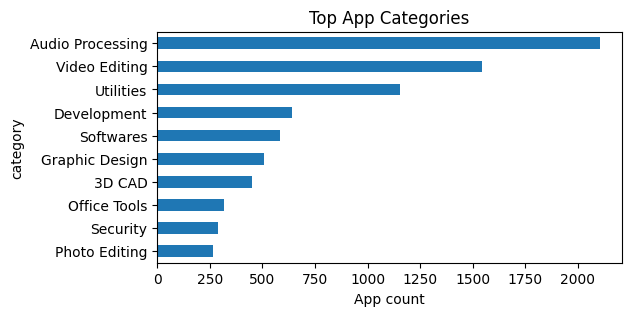

In [28]:
plt.figure(figsize=(6,3))
ax = newdf.category.value_counts().nlargest(10).sort_values(ascending=True).plot.barh()
ax.set_title("Top App Categories")
ax.set_xlabel("App count")

In [29]:
def filter_dev(dev):
    if len((dev.split())) > 4:
        return np.nan
    else:
        return dev

In [30]:
newdf['developer'] = newdf['developer'].map(filter_dev)
# newdf['developer']#.map(lambda x: len((x.split())) < 3)

In [31]:
newdf.dropna(inplace=True)

In [32]:
newdf.shape

(15046, 12)

In [33]:
nlp_df = newdf[["name","developer","category", "desc", "features", "img_link"]]
nlp_df = nlp_df.dropna().drop_duplicates()

In [34]:
nlp_df = nlp_df.drop((nlp_df[nlp_df['developer'] == 'Free'].index.values))

In [35]:
nlp_df = nlp_df[nlp_df['developer'] != 'VideoHive']

I want to remove softwares from VideoHive as they are very repetitive in nature an doutlier in our dataset 

<Axes: ylabel='developer'>

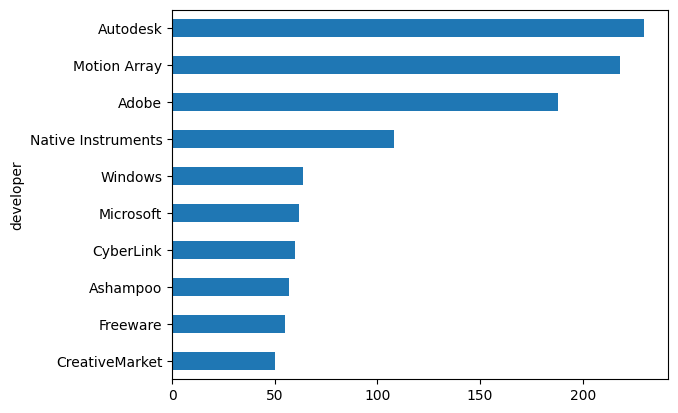

In [36]:

nlp_df['developer'].value_counts().nlargest(10).sort_values(ascending=True).plot.barh()

In [37]:
nlp_df['category'] = nlp_df.category.map(lambda x:x.split(",")[0])

<Axes: ylabel='category'>

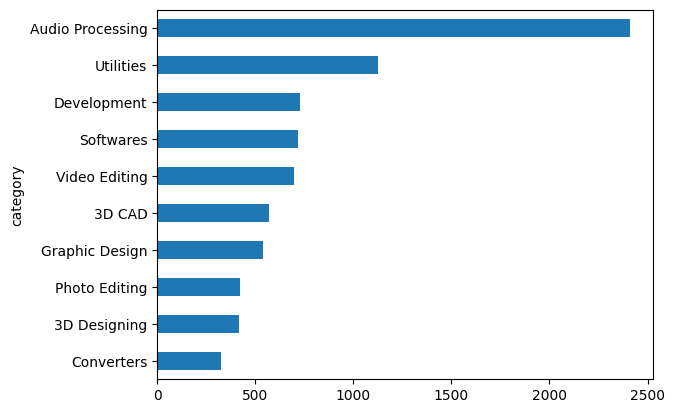

In [38]:
nlp_df['category'].value_counts().nlargest(10).sort_values(ascending=True).plot.barh()

In [39]:
print(nlp_df['developer'].value_counts())

developer
Autodesk              230
Motion Array          218
Adobe                 188
Native Instruments    108
Windows                64
                     ... 
Better File Rename      1
BootIt Bare Metal       1
DiskPulse               1
ACD Systems             1
Open Source             1
Name: count, Length: 7381, dtype: int64


In [40]:
nlp_df['tags'] = nlp_df['desc'] + nlp_df['features']

In [41]:
nlp_df.desc[0]

'Valentina Studio Pro 2024 is an award-winning application for modelling, reporting, editing, and managing the database. It provides a wide range of compression tools, diagnose capabilities, cloning functions, reindexing and defragment tools enabling users to create, alter, and browse various database elements, including tables, fields, indexes, and triggers. It enables database developers to easily run queries, administer and explore a wide range of popular databases such as MySQL, Valentina DB, PostgreSQL, MariaDB and SQLite. The GUI is neat and clean offering smooth navigation between the various database editing functions. It also supports simultaneous handling for multiple objects in multiple databases. You can also download Database Workbench Pro Free Download. Valentina Studio Pro 2024 is the ultimate suite which offers a perfect solution for comprehensive database development and management throughout the entire lifecycle. It enables database developers to create and modify all

In [42]:
n_na = nlp_df.isna().sum(axis=0)
n_na.round(2)  # Percentage of missing values

name         0
developer    0
category     0
desc         0
features     0
img_link     0
tags         0
dtype: int64

In [43]:
X = nlp_df.iloc[:,[0,1,3,4,5,6]]
Y = nlp_df['category']

[0.0, 0.17322494784547873, 0.25408244011222214, 0.3063088986403856, 0.3578879217322495, 0.40810013668081435, 0.4492482555211855, 0.4881663189698583, 0.5186677217466369, 0.5487375008992159, 0.5721890511473995, 0.5949931659592835, 0.6172937198762679, 0.6361412847996547, 0.6516797352708438, 0.6666426875764333, 0.6811020789871233, 0.6947701604201136, 0.7073591827926049, 0.7187972088338969]


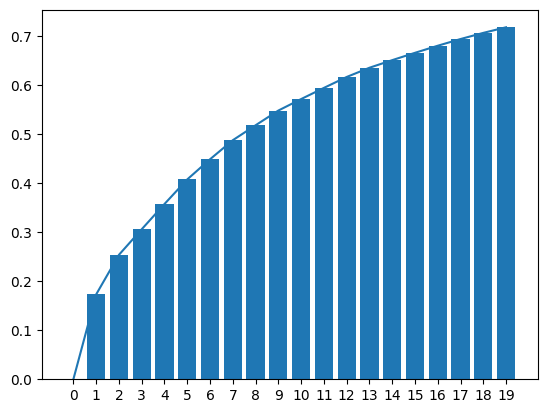

In [44]:
n_category_to_percent = [nlp_df.category.value_counts().nlargest(i).sum() / nlp_df.shape[0] for i in range(20)]
print(n_category_to_percent)
plt.bar(x=range(20),height = n_category_to_percent, tick_label = range(20))
plot = plt.plot( n_category_to_percent)
# Roughly 60 percent of the data.


#### By seeing the above graph top 10 categories can be a suitable option because after that we arent getting more of the dataset. There is a tradeoff here between the categories and dataset size.

In [45]:
top_10_cat = nlp_df.category.value_counts().nlargest(10).index.values

#### We have 160 categories of apps in our dataset. I might choose the top 10 categories for modelling, but then the dataset will be reduced to around 60%

In [46]:
reduce_filter = nlp_df['category'].map(lambda x:x in top_10_cat)
top_10_df = nlp_df[reduce_filter]


In [47]:
print(nlp_df.info())
nlp_df.sample()
print(nlp_df.developer.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 13901 entries, 0 to 15106
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       13901 non-null  object
 1   developer  13901 non-null  object
 2   category   13901 non-null  object
 3   desc       13901 non-null  object
 4   features   13901 non-null  object
 5   img_link   13901 non-null  object
 6   tags       13901 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB
None
developer
Autodesk              230
Motion Array          218
Adobe                 188
Native Instruments    108
Windows                64
                     ... 
Better File Rename      1
BootIt Bare Metal       1
DiskPulse               1
ACD Systems             1
Open Source             1
Name: count, Length: 7381, dtype: int64


In [48]:
nlp_df['desc'].astype(str)

0        Valentina Studio Pro 2024 is an award-winning ...
1        Paragon APFS for Windows 2024 is a professiona...
2        Master Packager Pro 2024 is a professional app...
3        Topaz Gigapixel AI 2024 is a professional phot...
4        Navicat Premium 2024 is a powerful and effecti...
                               ...                        
15102    AVG PC Tune up 2013 is a tool whose main respo...
15103    The tool has a  very simple installation proce...
15104    While watching movies and other videos on your...
15105    Microsoft Dynamics CRM is the tool which is su...
15106    With Adobe InDesign, interactive documents can...
Name: desc, Length: 13901, dtype: object

In [51]:
df.query("developer == 'Paragon'")

,name,category,developer,release,setup_size,setup_type,compatibility,operating_system,ram_required,hdd_space,...,extra_10,extra_11,extra_12,extra_13,extra_14,extra_15,extra_16,extra_17,extra_18,extra_19
8816,Paragon ReFS for Windows,Utilities,Paragon,07th Aug 2020,30 MB,Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/8.1/10.,512 MB of RAM required.,40 MB of free space required.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14047,Paragon Hard Disk Manager Advanced 2019,Utilities,Paragon,10th Jan 2019,"138 MB, 155 MB",Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows XP/Vista/7/8/8.1/10,512 MB of RAM required.,400 MB of free space required.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15528,Paragon Hard Disk Manager 15 Premium,Utilities,Paragon,19th Feb 2018,"470 MB, 737 MB",Offline Installer / Full Standalone Setup,32 Bit (x86) / 64 Bit (x64),Windows 7/8/8.1/10,256 MB of RAM required.,900 MB of free space required.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
top_10_df.reset_index().to_csv('../data/processed/top10categorys.csv')

In [50]:
nlp_df.reset_index().to_csv('../data/processed/nlp.csv')